In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'
data_path = repo_path / 'data'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Google collab setup cell
# setup computing
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# define paths
repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'
data_path = full_repo_path / 'data'
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

using device: cpu
Mounted at /content/drive


In [18]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings
from notebooks.plot_fns import plot_accs
from notebooks.train_fns import Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier, ConvnextTransferClassifier, TransformerTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [8]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=True)
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path/'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [11]:
# load subset indices
filename = 'images_spec_realtree_idxs.csv'
realtree_idxs = np.loadtxt(full_repo_path / 'data' / filename).astype(int).tolist()
realtree_idxs = None

# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=None)

dataloader sizes: {'all': 32832, 'train': 22161, 'validate': 7387, 'test': 3284, 'sampler': 4}


# Baseline models

In [21]:
# define small loader for testing
random_idxs = np.random.choice(range(len(treeds)), 200).tolist()
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.01, val_split=0.25, 
    sampleN=4, batch_size=20, seed=1)

# setup testing parameters
loaders = small_loaders
sizes = small_ds_sizes
# loaders = dataloaders
# sizes = ds_sizes

# define some constants
num_epochs = 3

print(f'Performance of random chance:', 1 / len(class_names))

dataloader sizes: {'all': 200, 'train': 148, 'validate': 50, 'test': 2, 'sampler': 4}
Performance of random chance: 0.14285714285714285


## Softmax

In [19]:
# define the model, optimizer, and scheduler (for lr decay)
model_sm = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names)),
    nn.Softmax(dim=1)
    ).to(device)
optimizer = optim.SGD(model_sm.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.NLLLoss()
acc_sm = train_model(model_sm, criterion, optimizer, schedlr,
                             loaders, sizes, device, num_epochs)
plot_accs({key: acc_sm[key] for key in ['epoch_train', 'epoch_validate']})

train epoch: [1/3] Loss: -0.1755 ACC@1: 18.24%: 100%|██████████| 5/5 [01:49<00:00, 21.92s/it]
validate epoch: [1/3] Loss: -0.0957 ACC@1: 10.00%: 100%|██████████| 2/2 [00:37<00:00, 18.91s/it]
train epoch: [2/3] Loss: -0.2426 ACC@1: 25.00%: 100%|██████████| 5/5 [01:21<00:00, 16.39s/it]
validate epoch: [2/3] Loss: -0.1404 ACC@1: 14.00%: 100%|██████████| 2/2 [00:29<00:00, 15.00s/it]
train epoch: [3/3] Loss: -0.3130 ACC@1: 31.08%: 100%|██████████| 5/5 [01:22<00:00, 16.50s/it]
validate epoch: [3/3] Loss: -0.1265 ACC@1: 12.00%: 100%|██████████| 2/2 [00:29<00:00, 14.77s/it]



Returning best model, with validation accuracy 0.14


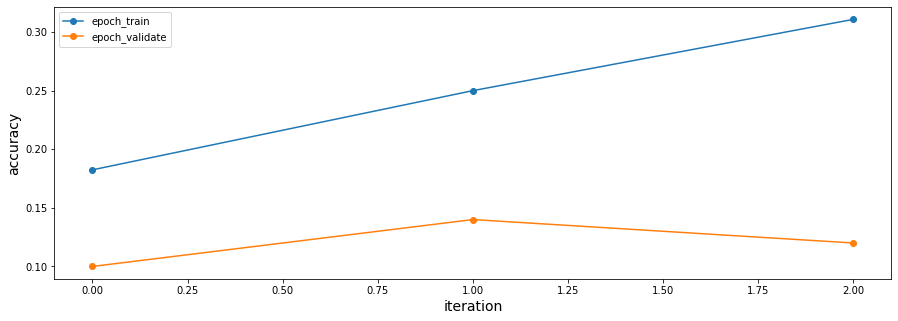

In [20]:
acc_sm = train_model(model_sm, criterion_sm, optimizer_sm, schedlr_sm,
                             loaders, sizes, device, num_epochs)
plot_accs({key: acc_sm[key] for key in ['epoch_train', 'epoch_validate']})

## Hinge loss (SVM)

validate epoch: [3/3] Loss: 7.4694 ACC@1: 18.00%: 100%|██████████| 3/3 [00:17<00:00,  6.00s/it]


Returning best model, with validation accuracy 0.2


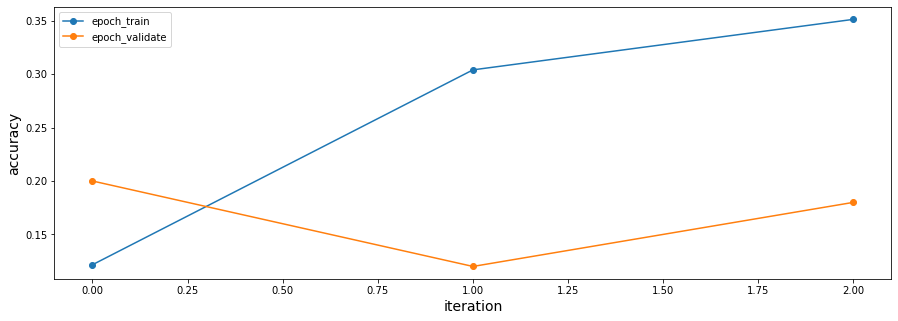

In [22]:
# define model
model_mh = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_mh.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.MultiMarginLoss()
# run model and plot results
acc_mh = train_model(model_mh, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_mh[key] for key in ['epoch_train', 'epoch_validate']})

## 2-layer fully connected net

In [1]:
# define model
hidden_layer_size = 4000
model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
# run model and plot results
acc_fc = train_model(model_fc, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_fc[key] for key in ['epoch_train', 'epoch_validate']})

NameError: ignored

## 3-layer ConvNet

In [ ]:
# define model
channel_1 = 32
channel_2 = 16
# padding chosen to preserve original H/W dimensions
model_cn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, padding=(5 - 1)//2),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, padding=(3 - 1)//2),
    nn.ReLU(), 
    Flatten(),
    nn.Linear(channel_2*IMAGE_DIM*IMAGE_DIM, len(class_names))
    ).to(device)
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_cn = lr_scheduler.StepLR(optimizer_cn, step_size=2, gamma=0.1) # lr decay
criterion_cn = nn.CrossEntropyLoss()
# run model and plot results
acc_cn = train_model(model_cn, criterion_cn, optimizer_cn, schedlr_cn,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_cn[key] for key in ['epoch_train', 'epoch_validate']})

## Summarize

In [ ]:
key = 'epoch_validate'

baseline_results = {
    'softmax': min(acc_sm[key]),
    'svm': min(acc_mh[key]),
    '2layer_fc': min(acc_fc[key]),
    '3layer_cnn':min(acc_cn[key])
}
baseline_results

# Transfer learning models

## Training only the last fully connected layer

### Resnet

validate epoch: [3/3] Loss: 1.9837 ACC@1: 6.00%: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]



Returning best model, with validation accuracy 0.08


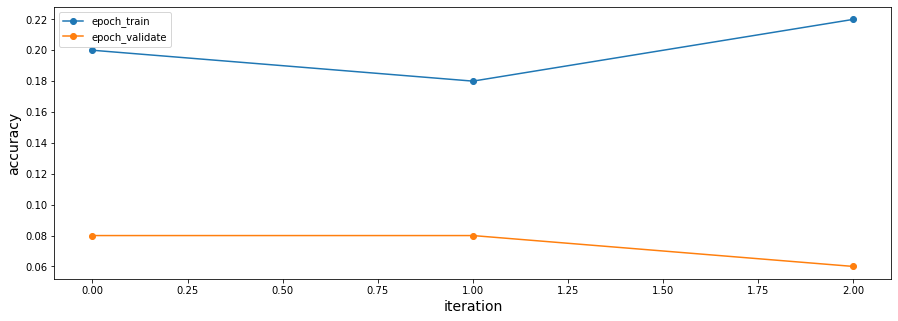

In [ ]:
m_resnet = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
optimizer = optim.SGD(m_resnet.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_res = train_model(m_resnetfc, criterion, optimizer, schedlr,
                        loaders, sizes, device, num_epochs)
plot_accs({key: acc_res[key] for key in ['epoch_train', 'epoch_validate']})

### Convnext

validate epoch: [3/3] Loss: 1.9756 ACC@1: 12.00%: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]



Returning best model, with validation accuracy 0.14


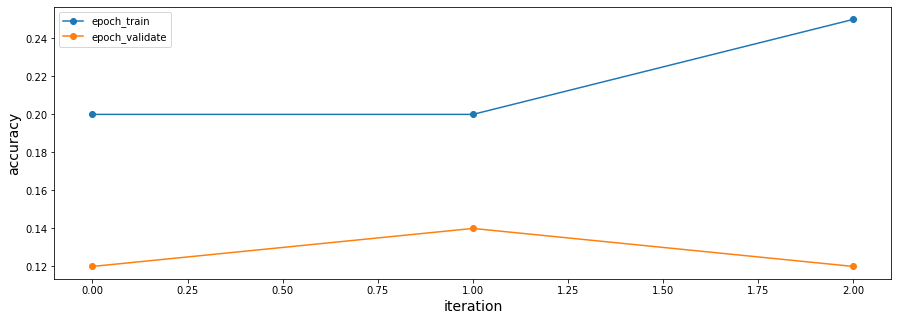

In [ ]:
m_convnext = ConvnextTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
optimizer = optim.SGD(m_convnext.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_convnext = train_model(m_convnext, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_convnext[key] for key in ['epoch_train', 'epoch_validate']})

### Transformer

In [ ]:
m_trans = TransformerTransferClassifier(num_classes=len(class_names), retrain_last_encoder=False)
optimizer = optim.SGD(m_trans.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_trans = train_model(m_trans, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_trans[key] for key in ['epoch_train', 'epoch_validate']})

### Summarize transfer learning of last fully-connected layer

In [ ]:
key = 'epoch_validate'
transfer_resultsfc = {
    'resnetfc': min(acc_res[key]),
    'convnextfc': min(acc_convnext[key]),
    'transformerfc':min(acc_trans[key])
}
transfer_resultsfc

In [2]:
# git saver
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'subset species dataset'
!git push

/content/drive/My Drive /git/tree-finder
[main ad9a4f2] subset species dataset
 8 files changed, 39 insertions(+), 13 deletions(-)
 rewrite notebooks/__pycache__/data_processing.cpython-37.pyc (76%)
 create mode 100644 notebooks/__pycache__/setup.cpython-37.pyc
 rewrite notebooks/preprocess_images.ipynb (79%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (90%)
Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.37 MiB | 5.30 MiB/s, done.
Total 12 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/etrieschman/tree-finder
   ea85ecb..ad9a4f2  main -> main
